In [75]:
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.stats import distributions
from scipy.stats import norm, beta
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle

import pdb

data_path = "./results.data"

In [76]:
def generate_distribution(n_words, n_samples):
    """generates a distribution of words through urn-sampling (if we sample a word, we add a copy of that word to the urn)

    Args:
        n_words (int): number of words in the urn
        n_samples (int): number of times we sample from the urn

    Returns:
        np.array: original set of words, in original order
        np.array: final distribution of words, sorted by word index
    """
    words = [i for i in range(n_words)]
    words_original = words.copy()
    for i in range(n_samples):
        if i % 1000 == 0:
            print("Step: {}/{}".format(i, n_samples))
        np.random.shuffle(words)
        words.append(words[0])

    words.sort()

    return np.array(words_original), np.array(words)


In [77]:
def parallel_loop(iteration_idx):
    n_words = 500
    n_samples = 100000
    words, word_dist = generate_distribution(n_words, n_samples)

    # get counts of each number and sort
    _, counts = np.unique(word_dist, return_counts=True)
    sorted_idx = np.argsort(counts)
    words, counts = np.flip(words[sorted_idx]), np.flip(counts[sorted_idx])

    return (words, counts)


In [78]:
figsize = (8, 3)
dpi = 300
n_runs = 100
# n_runs = 1
iteration_list = [i for i in range(n_runs)]


In [79]:
# # do not run unless necessary, this takes a few hours for a full sim
# output_list = Parallel(n_jobs=-1)(map(delayed(parallel_loop), iteration_list))
# with open(data_path, "wb") as f:
#     pickle.dump(output_list, f)

In [80]:
with open(data_path, "rb") as f:
    output_list = pickle.load(f)

## Problem 1
Simulate for a 500 word language for a large number of iterations (100, 000) and see what happens. Does it represent Zipf's law?

If following Zipf, should be roughly linear in a log-log plot


In [92]:
counts_1 = output_list[0][1]


In [93]:
x = np.arange(1, len(counts_1)+1)
y = counts_1

def fit_func(x, a, b):
    return (a/x)**b

params, param_cov = curve_fit(fit_func, x, y, p0=[149185.00123291, 0.45], maxfev=500)
a, b = params

rmse = mean_squared_error(counts_1, fit_func(x, a, b), squared=False)
r2 = r2_score(counts_1, fit_func(x, a, b))


In [94]:

# number of data points
n = len(y)
# number of parameters
p = len(params)

dof = max(0, n-p)

# 95% confidence interval
alpha = 0.05
t_val = distributions.t.ppf(1.0 - alpha/2.0, dof)

# for i, p, var in zip(range(n), params, np.diag(param_cov)):
#     sigma = var**0.5
#     print(i, p, p-sigma*t_val, p+sigma*t_val)

# sigma = np.diag(param_cov)[0]**0.5
# a_list = [a-sigma*t_val, a+sigma*t_val]

# sigma = np.diag(param_cov)[1]**0.5
# b_list = [b-sigma*t_val, b+sigma*t_val]


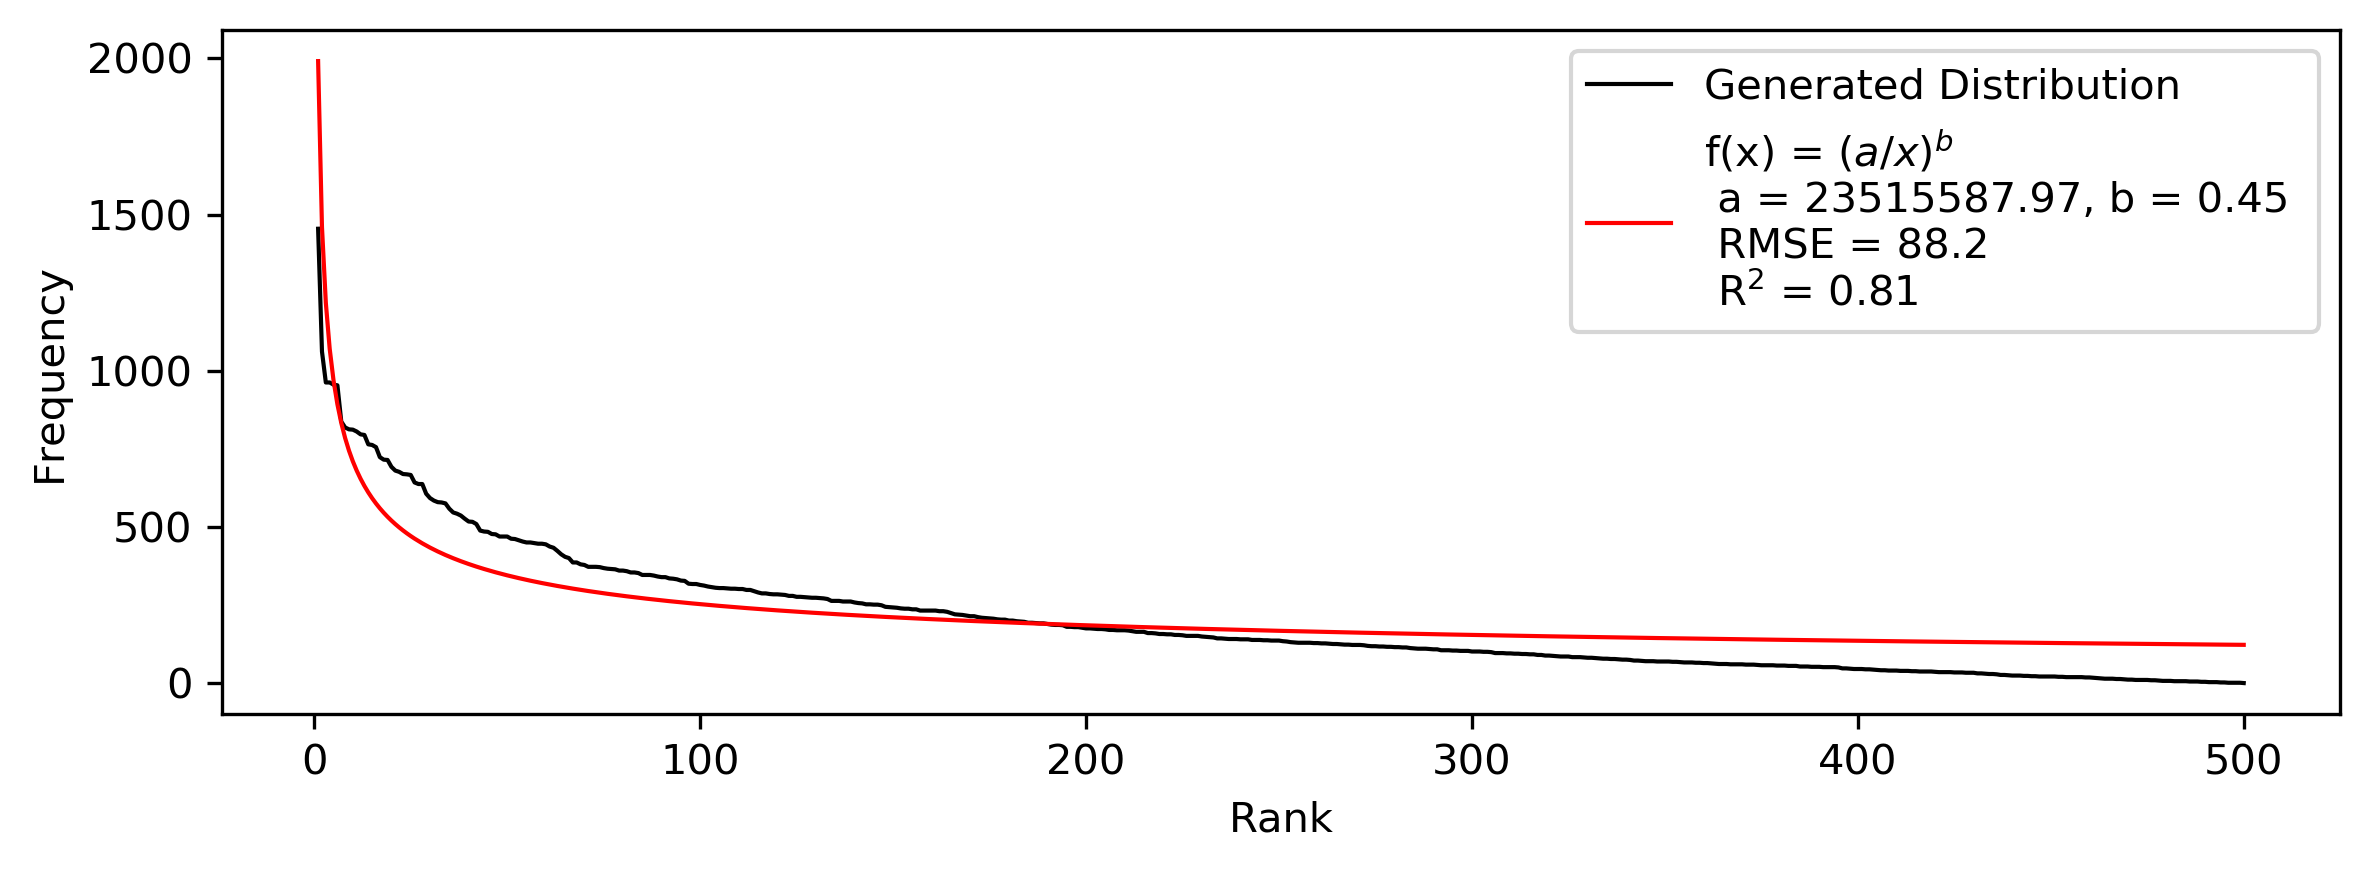

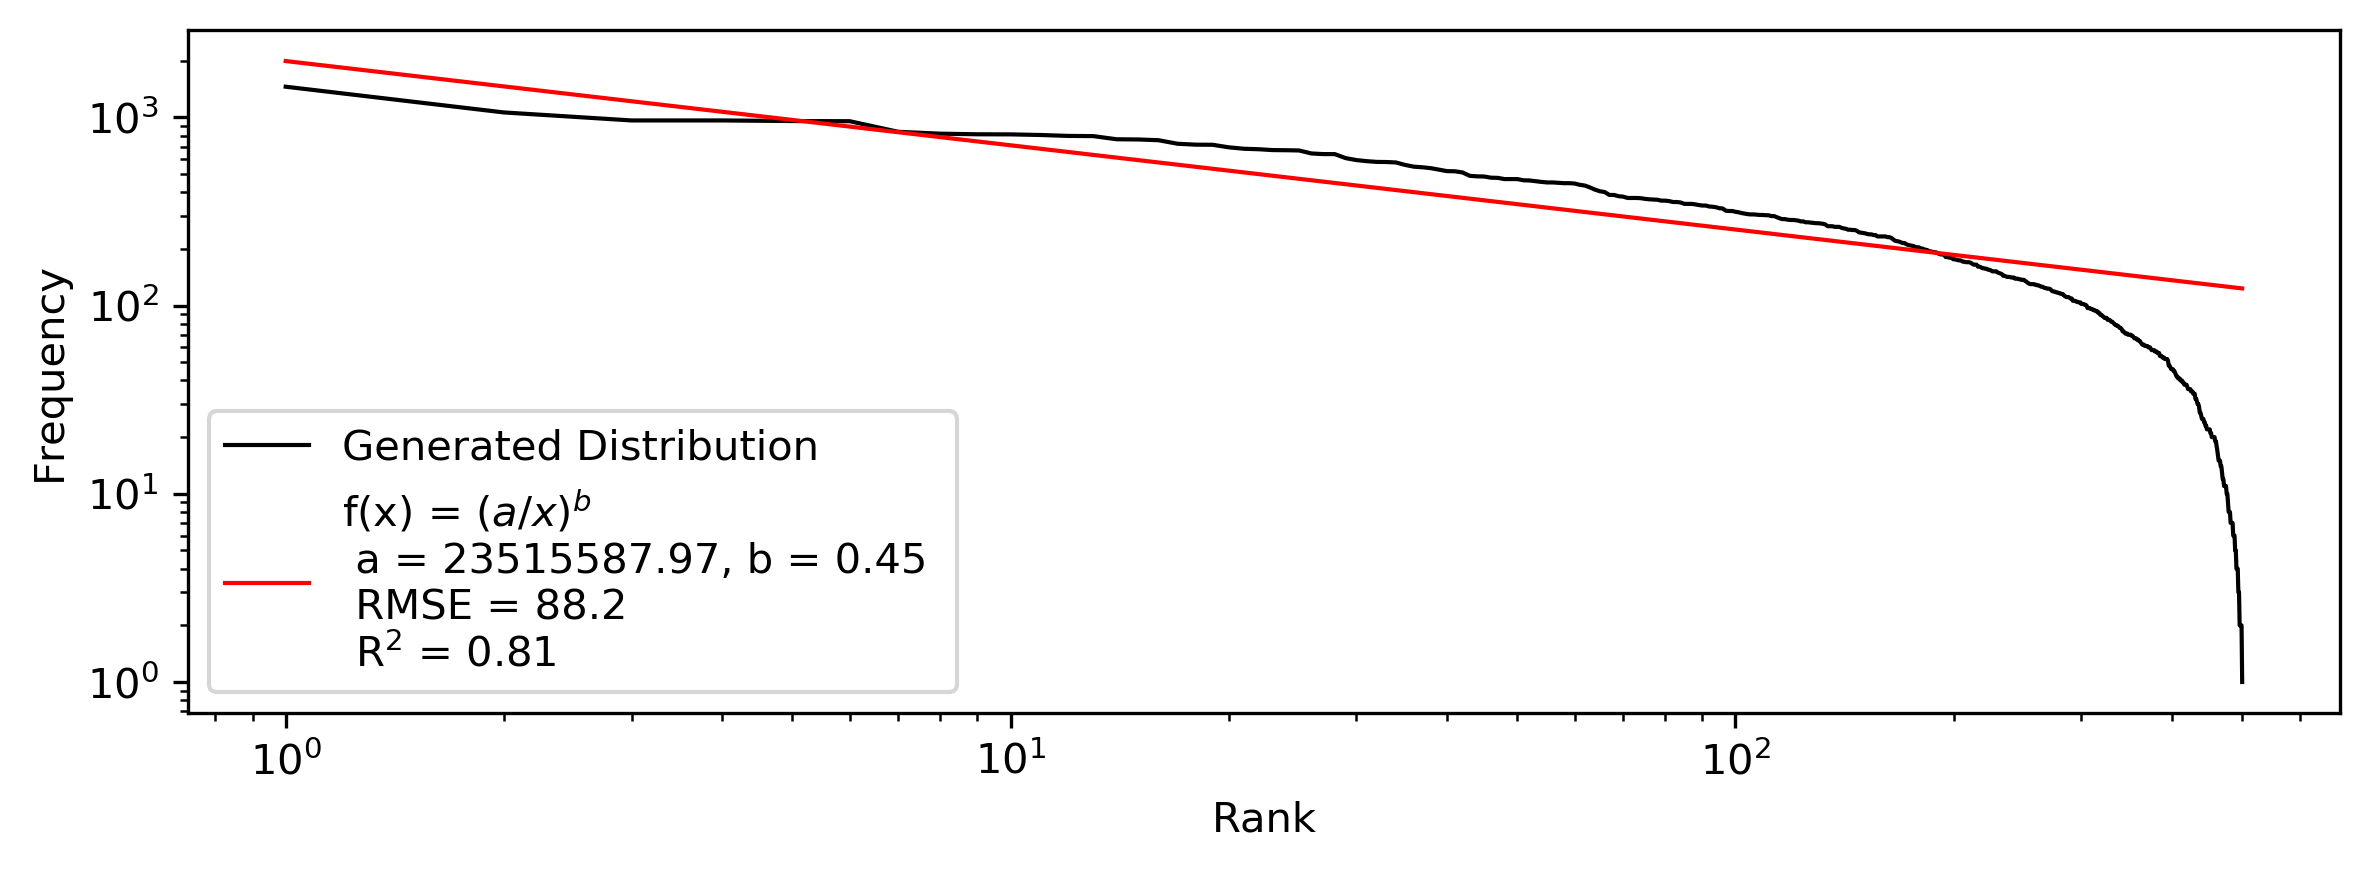

In [100]:
# # # standard plot
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
plt.plot(x, counts_1, color='k', linewidth = 1, label="Generated Distribution")
label_str = "f(x) = $(a/x)^b$ \n a = {}, b = {} \n RMSE = {} \n R$^2$ = {}"\
            .format(round(a,2), round(b,2), round(rmse, 2), round(r2, 2))

plt.plot(x, fit_func(x, a, b), color='r', linewidth = 1, label=label_str)

plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("./exp_1_plot.jpg")

plt.show()

# log log plot
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
plt.loglog(x, counts_1, color='k', linewidth = 1, label="Generated Distribution")
label_str = "f(x) = $(a/x)^b$ \n a = {}, b = {} \n RMSE = {} \n R$^2$ = {}"\
            .format(round(a,2), round(b,2), round(rmse, 2), round(r2, 2))

plt.loglog(x, fit_func(x, a, b), color='r', linewidth = 1, label=label_str)

plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("./exp_1_log.jpg")
plt.show()



## Problem 2

Simulate for a large number of trials and present your results

In [101]:
max_counts = np.zeros_like(output_list[0][1])

max_vals = np.zeros_like(output_list[0][1])
min_vals = np.zeros_like(output_list[0][1])

for i in range(len(output_list[0][0])):
    vals = []
    for j in range(n_runs):
        vals.append(output_list[j][1][i])
    max_vals[i] = np.max(vals)
    min_vals[i] = np.min(vals)

In [102]:
avg_counts = np.zeros_like(output_list[0][1])
for i in range(n_runs):
    avg_counts += output_list[i][1]

avg_counts = avg_counts/n_runs

In [103]:
x = np.arange(1, len(avg_counts)+1)
y = avg_counts

def fit_func(x, a, b):
    return (a/x)**b

params = curve_fit(fit_func, x, y, p0=[149185.00123291, 0.45], maxfev=5000)
a, b = params[0]


In [104]:
# fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
# for i in range(n_runs):
#     y = output_list[i][1]
#     plt.plot(x, y, linewidth=0.5)

# plt.plot(x, max_vals, color="k", linewidth=0.8)
# plt.plot(x, min_vals, color="k", linewidth=0.8)

# plt.xlabel("Rank")
# plt.ylabel("Frequency")
# plt.show()


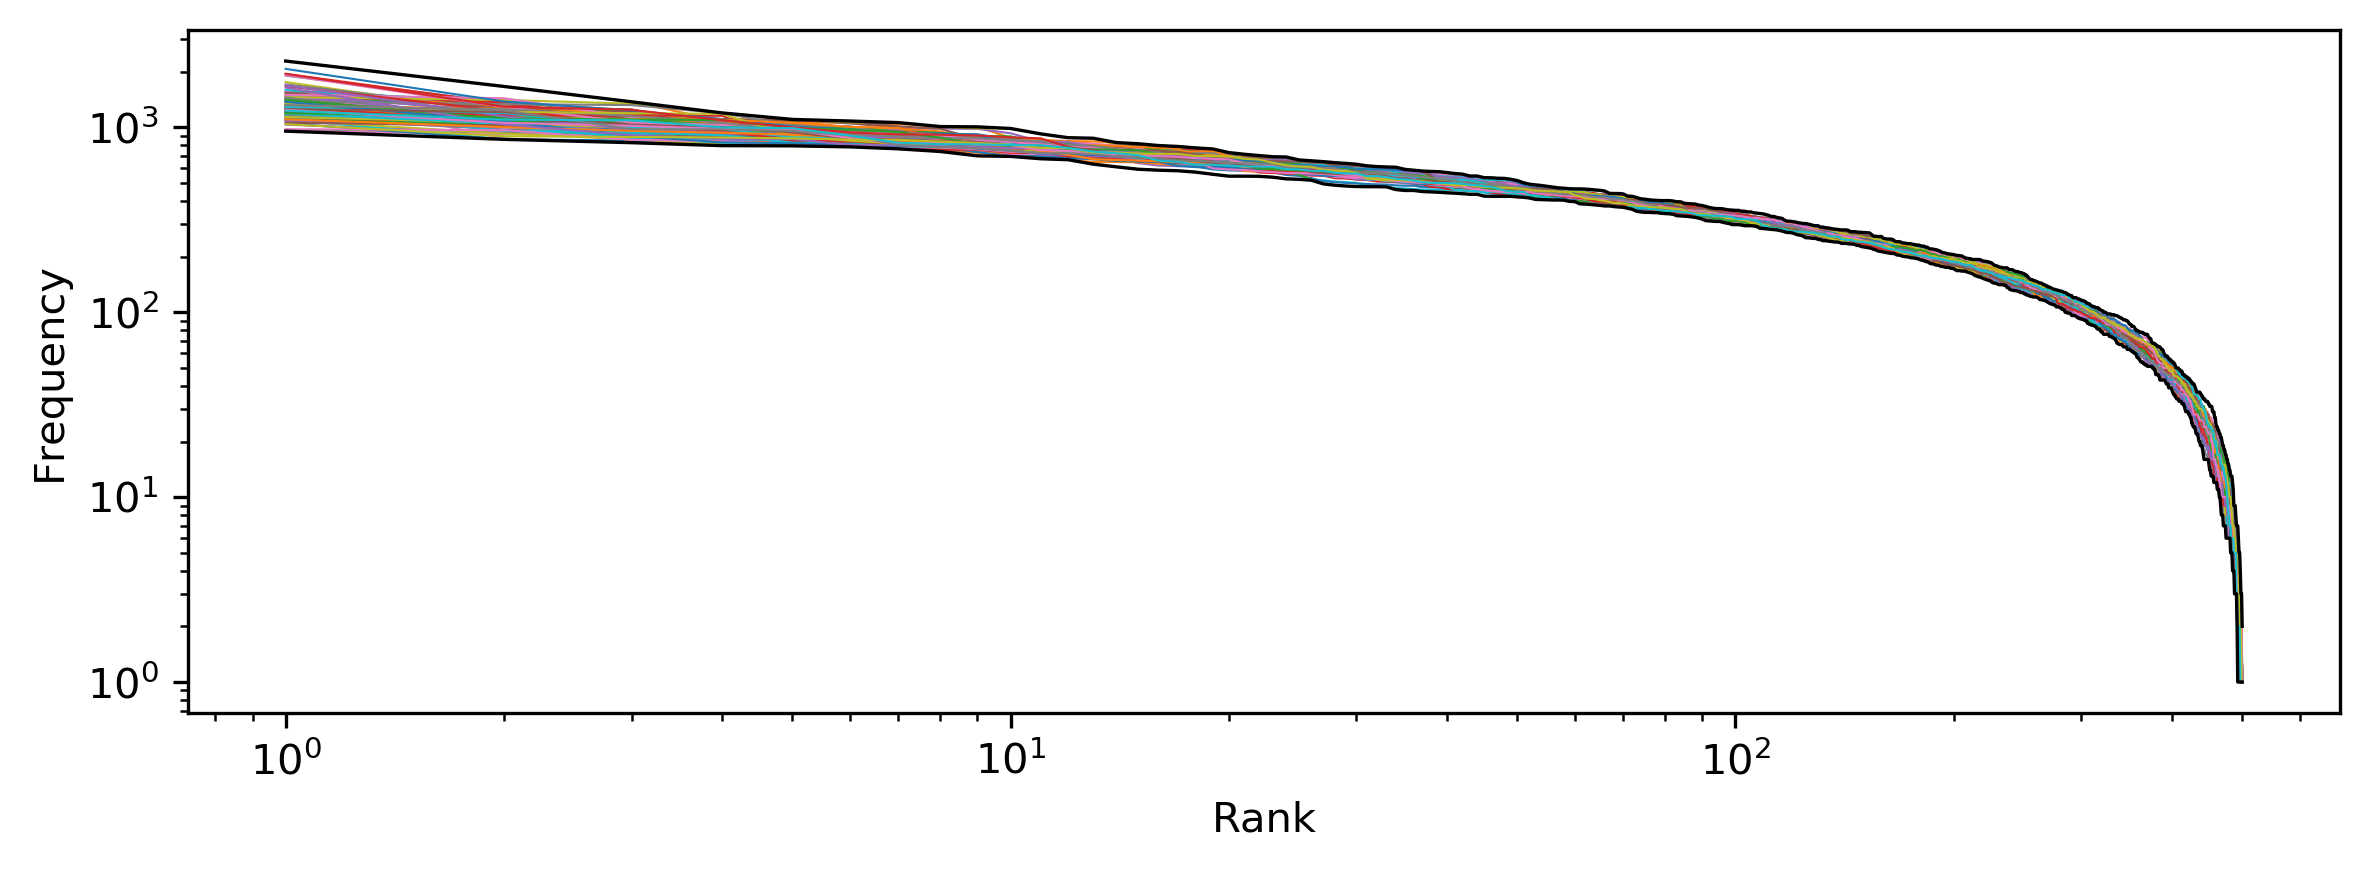

In [105]:
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
for i in range(n_runs):
    y = output_list[i][1]
    plt.loglog(x, y, linewidth=0.5)

plt.loglog(x, max_vals, color="k", linewidth=0.8)
plt.loglog(x, min_vals, color="k", linewidth=0.8)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("./exp_2_all.jpg")

plt.show()


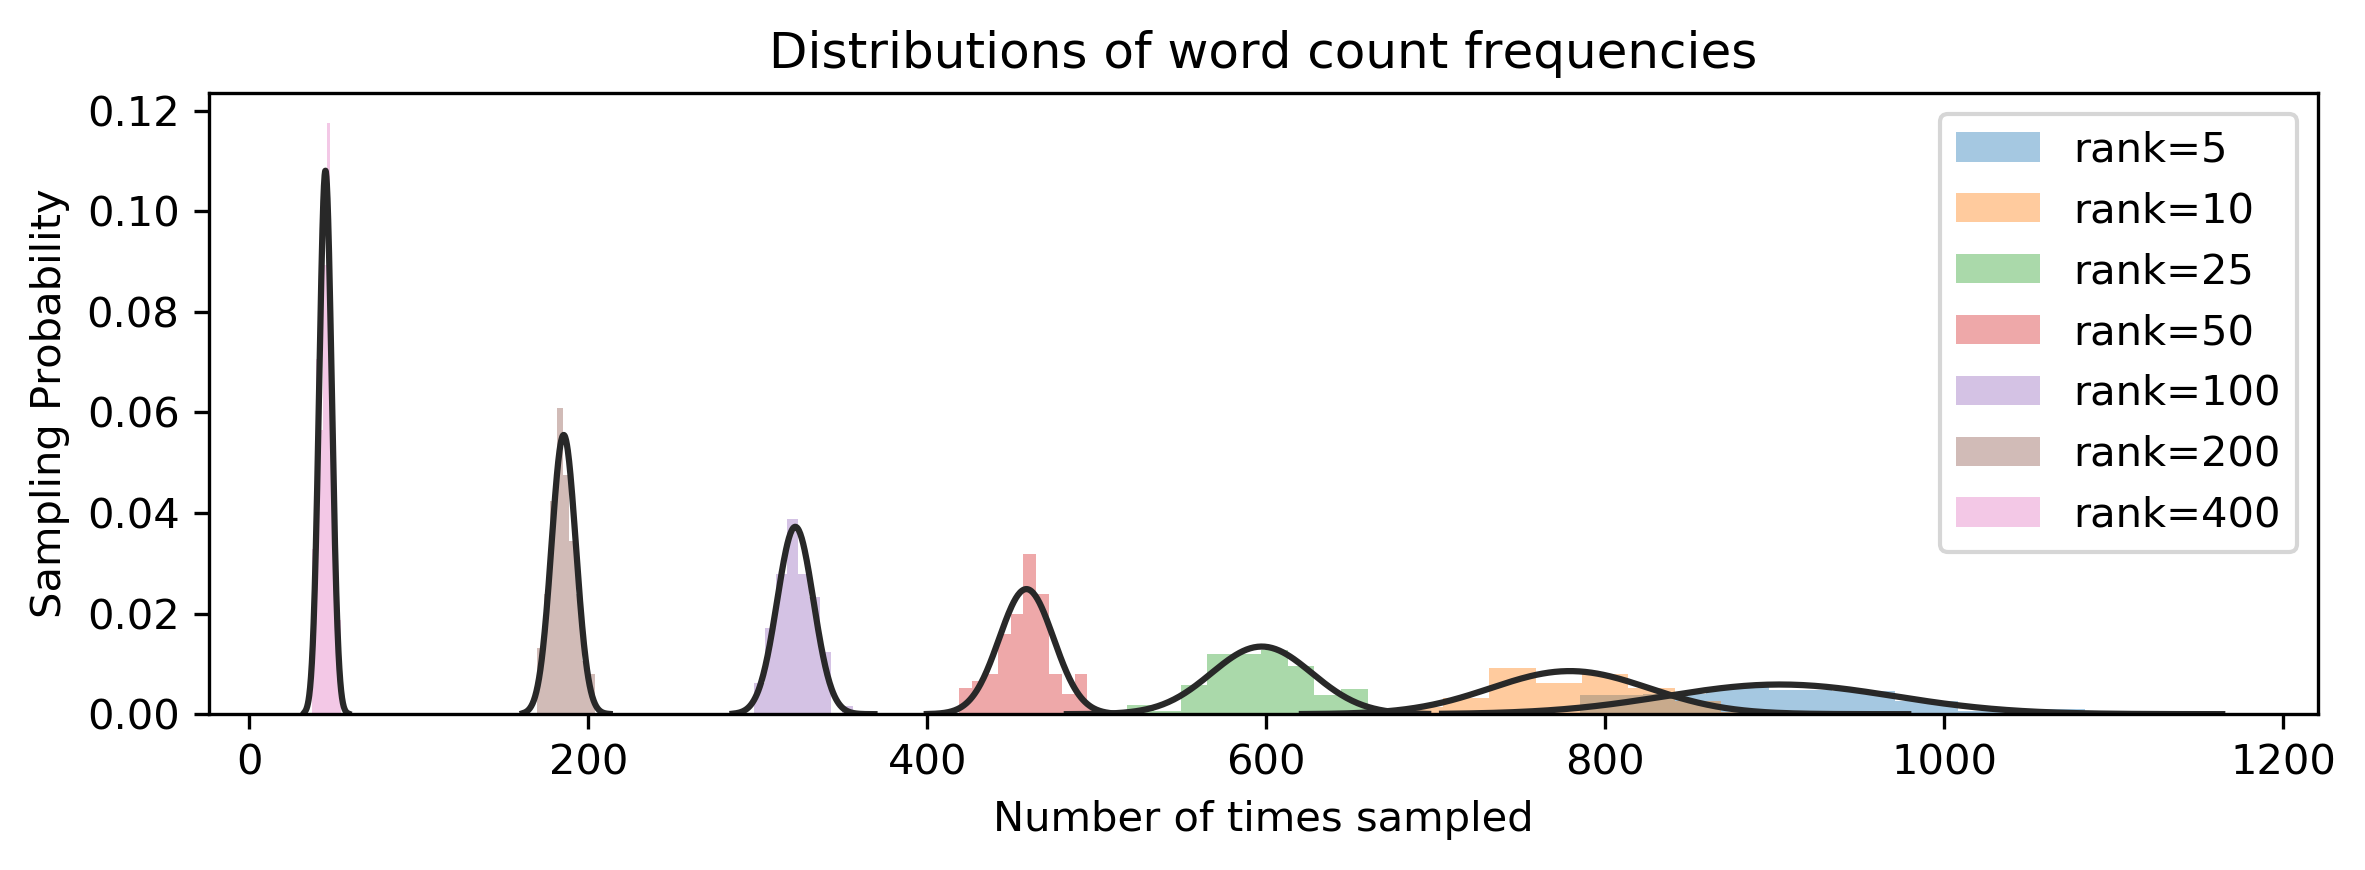

In [106]:
fig = plt.subplots(figsize=figsize, dpi=dpi)
counts = np.zeros((n_runs, 1))
plots = [5, 10, 25, 50, 100, 200, 400]

# for j in range(len(output_list[0][1])):
for j in plots:
    for i in range(n_runs):
        counts[i] = output_list[i][1][j]
    
    sns.distplot(counts, fit=norm, kde=False, label="rank={}".format(j))
    
#     plt.hist(counts, bins=15, alpha=0.6)
plt.xlabel("Number of times sampled")
plt.ylabel("Sampling Probability")
plt.title("Distributions of word count frequencies")
plt.legend()
plt.tight_layout()
plt.savefig("./exp_2_params.jpg")

plt.show()

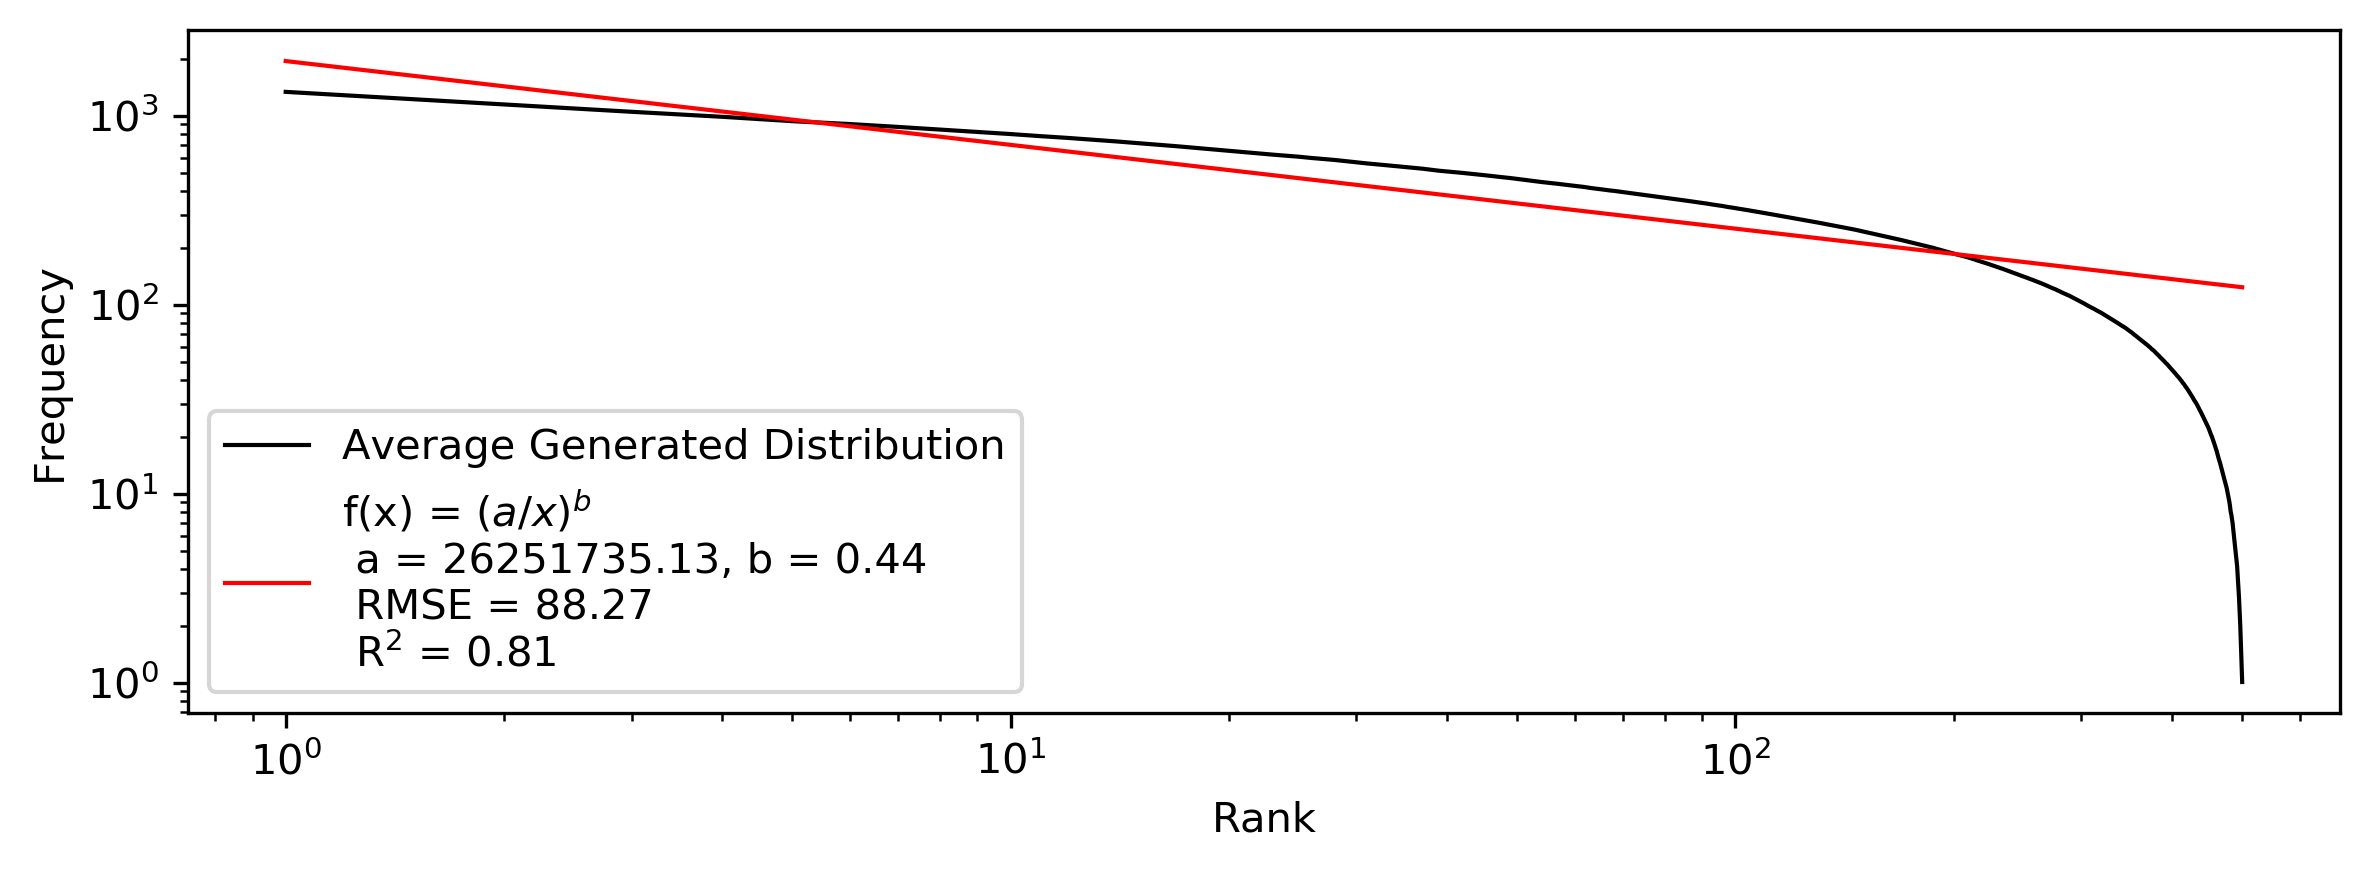

In [107]:
rmse = mean_squared_error(counts_1, fit_func(x, a, b), squared=False)
r2 = r2_score(counts_1, fit_func(x, a, b))

# # standard plot
# fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
# plt.plot(x, avg_counts, color='k', linewidth = 1, label="Frequency of Words")
# plt.plot(x, fit_func(x, a, b), color='r', linewidth = 1, label="f(x) = (a/x)**b \n a = {}, b = {}".format(round(a,2), round(b,2)))
# plt.xlabel("Rank")
# plt.ylabel("Frequency")
# plt.legend()
# plt.show()

# log log plot
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
plt.loglog(x, avg_counts, color='k', linewidth = 1, label="Average Generated Distribution")
label_str = "f(x) = $(a/x)^b$ \n a = {}, b = {} \n RMSE = {} \n R$^2$ = {}"\
            .format(round(a,2), round(b,2), round(rmse, 2), round(r2, 2))

plt.loglog(x, fit_func(x, a, b), color='r', linewidth = 1, label=label_str)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("./exp_2_avg.jpg")

plt.show()
